In [199]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

%matplotlib inline

0.8.1


In [3]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()

In [4]:
print config.models_file_name

Q:\\topic_modeling\\csi_science_collections.git\experiments\UCI_filtered_ngramm_trimmed_without_names\np_10_12_500_opt_dists\models.txt


In [5]:
models_file = open(config.models_file_name, 'a')

In [48]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model


def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      use_unigram_document_model=False,
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='ngramm'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='ngramm', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='ngramm', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [8]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=500, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.1
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.05
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model1')
model1 = tmp_model; tmp_model = None

[2016-12-10 20:33:32.478000] creating model
[2016-12-10 20:33:35.009000] adding scores
[2016-12-10 20:33:35.036000] fitting
[2016-12-10 20:36:52.445000] outputting
name = model1, n_topics = 500, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.1
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -0.05



In [11]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=10, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.1
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.05
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model2')
model2 = tmp_model; tmp_model = None

[2016-12-10 20:37:33.773000] creating model
[2016-12-10 20:37:35.541000] adding scores
[2016-12-10 20:37:35.552000] fitting
[2016-12-10 20:37:54.947000] outputting
name = model2, n_topics = 10, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.1
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -0.05



In [388]:
def euc_dist(p, q):
    return euclidean_norm(p - q)
def euc_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    norm = euc_dist(A.dot(x), b)
    res = A.T.dot(A.dot(x) - b)
    if norm != 0:
        res = res / norm
    return res
def cos_dist(p, q):
    p = p.reshape(-1, 1)
    q = q.reshape(-1, 1)
    return cosine_distances(p, q)[0][0]
def cos_dist_grad(b, A, x):
    x = x.reshape(-1, 1)
    b = b.reshape(-1, 1)
    y = A.dot(x)
    u = b.T.dot(y) # number
    deriv_u = A.T.dot(b) * x
    v = euclidean_norm(y) * euclidean_norm(b)
    nom = deriv_u * v - A.T.dot(A).dot(x) * u[0][0] * euclidean_norm(b) / euclidean_norm(y)
    denom = v * v
    if denom != 0:
        res = nom / denom
    else:
        res = nom
    return -res
def hellinger_dist(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2) 
def hellinger_dist_grad(b, A, x):
    y = A.dot(x)
    nom = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y)).dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_nan(b, A, x):
    y = A.dot(x)
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    tmp[np.isnan(tmp)] = 0
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res
def hellinger_dist_grad_eps(b, A, x):
    y = A.dot(x)
    y[y == 0] = 1e-3
    tmp = np.divide(np.sqrt(y) - np.sqrt(b), np.sqrt(y))
    nom = tmp.dot(A)
    denom = 2 * hellinger_dist(y, b) * np.sqrt(2)
    res = nom / denom 
    return res

In [404]:
def print_optimal_solution_eps(_sol):
    _eps = 1e-2
    x = _sol.x
    c = _sol.column_names
    x_mask = x >_eps
    x_cut = x[x_mask]
    c_cut = c[x_mask]
    combination = ', '.join(['{} : {}'.format(c_cut[ind], x_cut[ind]) for ind in range(len(x_cut))])
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{}: {}'.format(_sol.optimized_column, combination)
def print_optimal_solution(_sol, _distances=None, _saved_top_tokens=None):
    x = _sol.x
    c = _sol.column_names
    sorted_x = sorted(zip(x, c), reverse=True)[0 : NUM_INDICES]
    if _distances is not None:
        combination = ', '.join(['{0} : {1:0.2f} [{2:0.2f}]'.format(item[1], item[0], _distances[_sol.optimized_column][item[1]]) for item in sorted_x])
        combination += '\n' + distances_to_str_row(_distances, _sol.optimized_column, _n_topics=NUM_INDICES)
    else:
        combination = ', '.join(['{0} : {1:0.2f}'.format(item[1], item[0]) for item in sorted_x])
    print '============================'
    print 'fun = {}, optimized = {}'.format(_sol.fun, _sol.success)
    print '{} | {}'.format(_sol.optimized_column, combination)
    if _saved_top_tokens is not None:
        topics_str = optimal_solution_topics_to_str(_saved_top_tokens, _sol.optimized_column, sorted_x)
        print topics_str
    print '============================'
def unicode_list_to_str(_name, _list):
    return _name + ': ' + ' '.join(_list)
def optimal_solution_topics_to_str(_saved_top_tokens, topic_name, sorted_x):
    topics = [item[1] for item in sorted_x]
    topics.insert(0, topic_name)
    str = ""
    for topic_name in topics:
        str += unicode_list_to_str(topic_name, _saved_top_tokens[topic_name]) + '\n'
    return str
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        print '[{}] column num {} of {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def distances_to_str_row(distances, topic, _n_topics):
    values = distances[topic].sort_values().head(_n_topics)
    value = ', '.join(['{0} : [{1:0.2f}]'.format(values.index[ind], values[ind]) for ind in range(len(values))])
    str = 'closest by distance to {} | {}\n'.format(topic, value)
    return str
def calculate_distances_one_col(dist, phi, column): 
    distances = pd.DataFrame(0, index = range(1), columns=phi.columns)
    for idx, col in enumerate(phi.columns):
        distance = dist(column, phi[col])
        distances.iloc[0, idx] = distance
    return distances
def get_optimization_result(dist_fn, jac_dist_fn, phi, distances):
    opt_results = {}
    for col_idx, col in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)
        opt_results[col] = solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, col_idx, phi, distances, verbose=False):
    max_iter = 50
    col_name = phi.columns[col_idx]
    col = phi[col_name]
    # get n closest topics
    closest_indices = distances[col_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_indices]
    # delete zero rows from matrix
    phi_closest_nz = phi_closest[(phi_closest.T != 0).any()]
    col_nz = phi_closest_nz[col_name]
    # delete col from phi
    phi_cut_nz = phi_closest_nz.drop(col_name, axis=1)
    
    # opt solver
    n_columns = phi_cut_nz.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(col_nz, phi_cut_nz.dot(x))
    jac_fun = lambda x: jac_dist_fn(col_nz, phi_cut_nz, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    res['column_names'] = phi_cut_nz.columns
    res['optimized_column'] = col_name
    return res

In [254]:
N_CLOSEST_TOPICS = 25
phi1 = model1.get_phi()
phi1 = phi1[(phi1.T != 0).any()]
saved_top_tokens1 = model1.score_tracker['top_tokens_score'].last_tokens
phi = phi1
saved_top_tokens = saved_top_tokens1

In [184]:
ds_zero_col = solve_optimization_problem(hellinger_dist, None, 0, phi)

[2016-12-10 22:03:41.944000] calculating distances
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.860765081112
            Iterations: 35
            Function evaluations: 953
            Gradient evaluations: 35


In [191]:
distances = calculate_distances(hellinger_dist, phi, phi)
ds = get_optimization_result(hellinger_dist, None, phi, distances)
save_pickle_file(ds, 'dists_h_none.p')

[2016-12-10 22:19:02.426000] caclulating dist for column 0
[2016-12-10 22:19:04.127000] caclulating dist for column 1
[2016-12-10 22:19:05.808000] caclulating dist for column 2
[2016-12-10 22:19:07.510000] caclulating dist for column 3
[2016-12-10 22:19:09.736000] caclulating dist for column 4
[2016-12-10 22:19:11.102000] caclulating dist for column 5
[2016-12-10 22:19:12.773000] caclulating dist for column 6
[2016-12-10 22:19:14.360000] caclulating dist for column 7
[2016-12-10 22:19:16.021000] caclulating dist for column 8
[2016-12-10 22:19:17.855000] caclulating dist for column 9
[2016-12-10 22:19:19.401000] caclulating dist for column 10
[2016-12-10 22:19:21.006000] caclulating dist for column 11
[2016-12-10 22:19:22.558000] caclulating dist for column 12
[2016-12-10 22:19:24.311000] caclulating dist for column 13
[2016-12-10 22:19:25.830000] caclulating dist for column 14
[2016-12-10 22:19:27.430000] caclulating dist for column 15
[2016-12-10 22:19:29.001000] caclulating dist for 

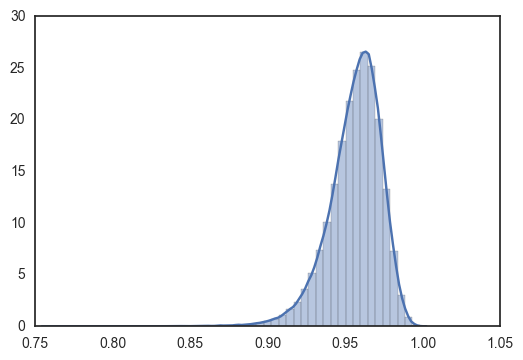

In [336]:
# построим распределение полученных distances
vals = distances.values.flatten()
sns.distplot(vals[vals != 0])

In [ ]:
# построим распределение полученных opt_fun 

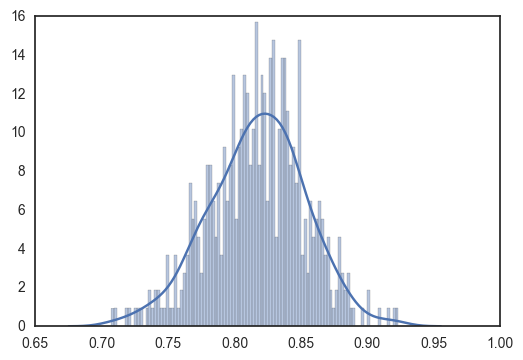

In [207]:
fs = [ds[col].fun for col in phi.columns]
sns.distplot(fs, bins=100)

In [ ]:
# посмотрим на топики, которые < 0.76 и > 0.89

In [214]:
low_th, high_th = 0.76, 0.89
small_dist_opts = {col: ds[col] for col in phi.columns if ds[col].fun < low_th}
large_dist_opts = {col: ds[col] for col in phi.columns if ds[col].fun > high_th}
print len(small_dist_opts), len(large_dist_opts)

29 8


In [221]:
for key, value  in small_dist_opts.iteritems():
    print_optimal_solution(_sol=value)

fun = 0.709351444397, optimized = True
topic_57 | topic_145 : 0.53, topic_498 : 0.17, topic_177 : 0.08, topic_80 : 0.05, topic_399 : 0.04
fun = 0.738238209879, optimized = True
topic_38 | topic_58 : 0.31, topic_359 : 0.26, topic_346 : 0.06, topic_161 : 0.06, topic_379 : 0.05
fun = 0.743417370783, optimized = True
topic_373 | topic_67 : 0.10, topic_178 : 0.10, topic_284 : 0.10, topic_136 : 0.10, topic_51 : 0.07
fun = 0.755007645115, optimized = True
topic_359 | topic_38 : 0.34, topic_363 : 0.28, topic_439 : 0.10, topic_401 : 0.06, topic_491 : 0.03
fun = 0.749524709385, optimized = True
topic_358 | topic_122 : 0.32, topic_117 : 0.26, topic_263 : 0.19, topic_163 : 0.05, topic_413 : 0.04
fun = 0.754684684987, optimized = True
topic_418 | topic_8 : 0.14, topic_241 : 0.12, topic_240 : 0.12, topic_3 : 0.09, topic_416 : 0.08
fun = 0.749000183063, optimized = True
topic_419 | topic_137 : 0.27, topic_381 : 0.18, topic_255 : 0.15, topic_49 : 0.11, topic_20 : 0.08
fun = 0.727051142601, optimized =

In [220]:
for key, value  in large_dist_opts.iteritems():
    print_optimal_solution(_sol=value)

fun = 0.900343446224, optimized = True
topic_30 | topic_463 : 0.14, topic_361 : 0.13, topic_487 : 0.10, topic_116 : 0.09, topic_299 : 0.08
fun = 0.910405840239, optimized = True
topic_307 | topic_62 : 0.22, topic_492 : 0.11, topic_293 : 0.09, topic_244 : 0.09, topic_161 : 0.08
fun = 0.923415845239, optimized = True
topic_309 | topic_36 : 0.50, topic_374 : 0.16, topic_67 : 0.12, topic_81 : 0.10, topic_164 : 0.05
fun = 0.890908207754, optimized = True
topic_388 | topic_269 : 0.23, topic_116 : 0.17, topic_347 : 0.12, topic_119 : 0.12, topic_464 : 0.06
fun = 0.920427835428, optimized = True
topic_391 | topic_467 : 0.37, topic_228 : 0.25, topic_400 : 0.03, topic_222 : 0.03, topic_166 : 0.03
fun = 0.89738875009, optimized = True
topic_60 | topic_499 : 0.21, topic_68 : 0.11, topic_380 : 0.10, topic_321 : 0.08, topic_44 : 0.07
fun = 0.916226701177, optimized = True
topic_243 | topic_396 : 0.13, topic_344 : 0.12, topic_282 : 0.10, topic_471 : 0.10, topic_149 : 0.09
fun = 0.900289657723, optimiz

In [ ]:
# выведем opt для некоторых из small_dist_opts

In [302]:
topic_name = u'topic_75'
other_topic_name = u'topic_74'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.752146957306, optimized = True
topic_75 | topic_74 : 0.29 [0.84], topic_124 : 0.28 [0.85], topic_3 : 0.10 [0.90], topic_1 : 0.06 [0.90], topic_220 : 0.04 [0.91]
closest by distance to topic_75 | topic_75 : [0.00], topic_74 : [0.84], topic_124 : [0.85], topic_1 : [0.90], topic_118 : [0.90]

topic_75: диалект лексика язык словарь карта литературный_язык вариант говор диалектный_язык изучение фонетика материал русский_диалектология национальный_язык норма
topic_74: гласный русский_язык говор слово произношение литературный_язык ударение звук австралийский_абориген мягкий_согласный древнерусский_язык носитель_русский_язык часть ять литр
topic_124: язык лингвист английский_язык разный_язык название лингвистика носитель вопрос слово факт простой различие помощь понятие родной_язык
topic_3: работа автор статья исследование тема монография издание труд изучение материал редактор вопрос книга коллега пора
topic_1: глагол существительное грамматика форма русский_язык синтаксис прилагател

In [304]:
topic_name = u'topic_92'
other_topic_name = u'topic_428'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.746066693353, optimized = True
topic_92 | topic_428 : 0.57 [0.80], topic_348 : 0.10 [0.90], topic_424 : 0.05 [0.92], topic_86 : 0.03 [0.91], topic_299 : 0.03 [0.92]
closest by distance to topic_92 | topic_92 : [0.00], topic_428 : [0.80], topic_226 : [0.90], topic_348 : [0.90], topic_86 : [0.91]

topic_92: фильм кино зритель экран просмотр смех реплика высказывание погружение эйзенштейн участие кадр аттракцион строка голливуд
topic_428: фильм кино кинематограф жанр режиссёр картина хоррор тема реж плохой_кино точка_зрение категория ужас зритель популярный_культура
topic_348: речь слово ошибка высказывание средство устный_речь собеседник общение тип выражение пауза ситуация новое письменный_текст форма
topic_424: мода восприятие знак иллюзия образ предмет воздействие одежда знание сторона постоянство опыт процесс ценность контекст
topic_86: цирк трюк номер артист единство стадо театр целое декорация мешок сцена зритель движение оазис теснота
topic_299: событие действие смысл случ

In [306]:
topic_name = u'topic_278'
other_topic_name = u'topic_280'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.736274434606, optimized = True
topic_278 | topic_280 : 0.43 [0.81], topic_95 : 0.22 [0.85], topic_64 : 0.11 [0.88], topic_39 : 0.05 [0.90], topic_162 : 0.05 [0.87]
closest by distance to topic_278 | topic_278 : [0.00], topic_280 : [0.81], topic_95 : [0.85], topic_133 : [0.86], topic_162 : [0.87]

topic_278: белка белок клетка приона цитоплазма домен шаперон агрегат состояние фибрилла дрожжи эукариот структура образ транскрипция
topic_280: молекула белок белка аминокислота нуклеотид секвенирование длина процесс нуклеиновый_кислота друг липид рид результат пептид группа
topic_95: клетка ткань работа токсин живой_система химический_вещество открытие тип_клетка концентрация функционирование лимфоцит тип зависимость частность живой_клетка
topic_64: структура полимер процесс синтез смесь эксперимент задача гидродинамика расчёт область простой динамика структура_белок образ простейшее
topic_39: днк молекула_днк генетический_информация крик уотсон двойной_спираль последовательность стр

In [307]:
topic_name = u'topic_410'
other_topic_name = u'topic_470'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.900289657723, optimized = True
topic_410 | topic_470 : 0.53 [0.92], topic_397 : 0.13 [0.95], topic_230 : 0.11 [0.95], topic_132 : 0.08 [0.96], topic_388 : 0.05 [0.96]
closest by distance to topic_410 | topic_410 : [0.00], topic_470 : [0.92], topic_317 : [0.95], topic_397 : [0.95], topic_230 : [0.95]

topic_410: перспектива будущее научный_сообщество новый_программа дисциплина специфика место профессия ивар_максут освещение проблема постнаука рекомбинация пресс изучение
topic_470: учёный постнаука открытие материал исследование фундаментальный_наука идея специалист работа вопрос новое передача способ будущее участие
topic_397: преподаватель преподавание дисциплина студент курс принцип ректор гумбольдт работа обществознание обучение рамка выбор задача цель
topic_230: страна китай сша индия инвестиция ввп отношение развитие япония торговля экономический_развитие фактор ес азия темп_рост
topic_132: англия тысячелетие монт древность период стен археология айсберг важный_роль долина 

In [308]:
topic_name = u'topic_418'
other_topic_name = u'topic_8'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.754684684987, optimized = True
topic_418 | topic_8 : 0.14 [0.87], topic_241 : 0.12 [0.86], topic_240 : 0.12 [0.88], topic_3 : 0.09 [0.89], topic_416 : 0.08 [0.87]
closest by distance to topic_418 | topic_418 : [0.00], topic_241 : [0.86], topic_8 : [0.87], topic_416 : [0.87], topic_313 : [0.87]

topic_418: диссертация аспирант работа степень совет задача проблема аспирантура ситуация список академический_сообщество защита вак написание критерий
topic_8: журнал публикация статья новость принцип знакомство любитель научный_журнал издательство профессионал результат тысяча ресурс открытый_доступ база
topic_241: задача мышление психолог решение инсайт проблема решение_задача этап психология исследование процесс группа момент цель психология_мышление
topic_240: решение принятие_решение ситуация выбор проблема правило общество большинство аукцион механизм риска полезность пример компания неопределённость
topic_3: работа автор статья исследование тема монография издание труд изучение м

In [ ]:
# по топ словам действительно похожи темы, причём иногда симметрично есть, а иногда нет
# те, что через сильные коэфициенты больше похожи?
# проверить те, что практически симметричны 
# выведем opt для некоторых из small_dist_opts

In [314]:
topic_name = u'topic_309'
other_topic_name = u'topic_36'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.923415845239, optimized = True
topic_309 | topic_36 : 0.50 [0.94], topic_374 : 0.16 [0.97], topic_67 : 0.12 [0.96], topic_81 : 0.10 [0.96], topic_164 : 0.05 [0.94]
closest by distance to topic_309 | topic_309 : [0.00], topic_164 : [0.94], topic_36 : [0.94], topic_418 : [0.95], topic_323 : [0.95]

topic_309: система образ новое смысл пора взгляд конец задача общий_теория социальный_система лумана парсонс вычислительный_метод движение работа
topic_36: компьютер задача алгоритм процессор область вычисление машина ошибка программный_обеспечение суперкомпьютер секвенатор решение компьютерный_наука скорость специалист
topic_374: смысл гуманитарный_наука подход критик перестройка идея поворот энциклопедия сфера работа оттепель новое термин традиционализм гуманитарный_дисциплина
topic_67: теория гипотеза образ факт математический_модель помощь объяснение результат вопрос принцип механизм построение распространение подход проверка
topic_81: движение ньютон кеплер течение окружность копе

In [315]:
topic_name = u'topic_243'
other_topic_name = u'topic_396'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.916226701177, optimized = True
topic_243 | topic_396 : 0.13 [0.95], topic_344 : 0.12 [0.94], topic_282 : 0.10 [0.95], topic_471 : 0.10 [0.95], topic_149 : 0.09 [0.96]
closest by distance to topic_243 | topic_243 : [0.00], topic_75 : [0.94], topic_344 : [0.94], topic_172 : [0.95], topic_272 : [0.95]

topic_243: метр литр плата факт основа число рамка астрель аста проблема форма нелинейность имя пресс лифшиц
topic_396: раздел глава область изложение специалист вопрос актуальность предмет разный_область введение сфера монография обзор изучение книга
topic_344: концепция этнос этнограф этнография дискуссия народ общность предшественник понятие нация отношение этничность влияние новое идея
topic_282: обряд посещение гость свадьба достопримечательность невеста место обычай машина среднее_возраст свадебный_обряд природный_объект похороны мотоцикл закон_мура
topic_471: насилие индивид критика вебер легитимность отношение общество макс_вебер актор характер социальный_реальность форма вл

In [313]:
topic_name = u'topic_410'
other_topic_name = u'topic_470'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.900289657723, optimized = True
topic_410 | topic_470 : 0.53 [0.92], topic_397 : 0.13 [0.95], topic_230 : 0.11 [0.95], topic_132 : 0.08 [0.96], topic_388 : 0.05 [0.96]
closest by distance to topic_410 | topic_410 : [0.00], topic_470 : [0.92], topic_317 : [0.95], topic_397 : [0.95], topic_230 : [0.95]

topic_410: перспектива будущее научный_сообщество новый_программа дисциплина специфика место профессия ивар_максут освещение проблема постнаука рекомбинация пресс изучение
topic_470: учёный постнаука открытие материал исследование фундаментальный_наука идея специалист работа вопрос новое передача способ будущее участие
topic_397: преподаватель преподавание дисциплина студент курс принцип ректор гумбольдт работа обществознание обучение рамка выбор задача цель
topic_230: страна китай сша индия инвестиция ввп отношение развитие япония торговля экономический_развитие фактор ес азия темп_рост
topic_132: англия тысячелетие монт древность период стен археология айсберг важный_роль долина 

In [312]:
# вроде даже если opt высокий, всё равно темы вроде похожи
# и там и там первые - ближайшие по расстоянию, логично

In [316]:
# посмотрим на <<симметричные>>
topic_name = u'topic_92'
other_topic_name = u'topic_428'
print_optimal_solution(ds[topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)
print_optimal_solution(ds[other_topic_name], _distances=distances, _saved_top_tokens=saved_top_tokens)

fun = 0.746066693353, optimized = True
topic_92 | topic_428 : 0.57 [0.80], topic_348 : 0.10 [0.90], topic_424 : 0.05 [0.92], topic_86 : 0.03 [0.91], topic_299 : 0.03 [0.92]
closest by distance to topic_92 | topic_92 : [0.00], topic_428 : [0.80], topic_226 : [0.90], topic_348 : [0.90], topic_86 : [0.91]

topic_92: фильм кино зритель экран просмотр смех реплика высказывание погружение эйзенштейн участие кадр аттракцион строка голливуд
topic_428: фильм кино кинематограф жанр режиссёр картина хоррор тема реж плохой_кино точка_зрение категория ужас зритель популярный_культура
topic_348: речь слово ошибка высказывание средство устный_речь собеседник общение тип выражение пауза ситуация новое письменный_текст форма
topic_424: мода восприятие знак иллюзия образ предмет воздействие одежда знание сторона постоянство опыт процесс ценность контекст
topic_86: цирк трюк номер артист единство стадо театр целое декорация мешок сцена зритель движение оазис теснота
topic_299: событие действие смысл случ

In [320]:
for idx in phi.index:
    val = phi[topic_name][idx]
    val_other = phi[other_topic_name][idx]
    if val != 0 or val_other != 0:
        print idx, val, val_other

автор 0.0 0.0077551
красота 0.0 0.00116458
дорога 0.000428391 3.31266e-05
проблема 0.0 0.00524335
вопрос 0.00409053 0.00319101
дмитрия 0.000433505 0.0
америка 0.00236797 0.0
журнал 0.00200578 0.00110529
конец 0.00438831 0.00303694
работа 0.0021662 0.000773385
момент 0.0 0.00358029
пора 0.0 0.00316419
сюжет 0.0 0.00485475
новый_форма 1.76624e-05 0.000321171
термин 0.00238779 0.0041048
исследовательский_программа 4.70327e-05 0.0
традиция 0.0 0.00014228
очередь 0.00108994 0.0
часть 0.0 0.00405267
лето 0.0 0.0001383
название 0.0 0.00159147
участник 0.003645 0.0
дом 0.000861592 0.0
творчество 0.0 0.00197238
дата 0.00144042 0.0
издание 0.000509953 0.0
товар 0.000341337 0.0
случай 0.0 0.00155534
общество 0.0 0.00206616
автор_книга 0.0 0.000632442
третье 0.0 0.000574692
половина 0.0 0.000100579
принцип 0.0 0.00301114
явление 0.0 0.00509165
порядок 0.000697966 0.0
тема 0.0 0.0162911
литература 0.0 0.000808911
число 0.000478861 0.00214819
сторона 0.0 0.00423341
ответ 0.00106641 0.0
описание 0.00

In [ ]:
# наберём из small dist тем набор, берем не похожие друг на друга
# 2 варианта: по th, по проверке входит ли в топ ближ

In [407]:
def get_topics_to_remove_by_threshold(small_dist_opts, distances):
    dist_threshold = 0.88
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda x: x.fun)
    topics_to_remove = []
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        dists_to_topics_to_remove = [distances[topic_name][t] for t in topics_to_remove]
        is_far = np.all(np.array(dists_to_topics_to_remove) > dist_threshold)
        if is_far:
            topics_to_remove.append(topic_name)
    return topics_to_remove
def get_topics_to_remove_by_closest_dist(small_dist_opts, distances):
    n_closest = 10
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda x: x.fun)
    topics_to_remove = []
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_closest = lambda topic, other_topic: np.any(distances[topic].sort_values().head(n_closest).index.values == other_topic)
        dists_to_topics_to_remove = [not is_closest(topic_name, t) for t in topics_to_remove]
        is_far = np.all(np.array(dists_to_topics_to_remove))
        if is_far:
            topics_to_remove.append(topic_name)
    return topics_to_remove
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull

In [378]:
topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(small_dist_opts, distances)
print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])

topic_145: кварк мезон античастица антиматерия материя частица пара асимметрия эксперимент барион протон
topic_356: солнечный_система планета тело орбита астероид комета юпитер аппарат гигант земля планет
topic_327: нейрон мозг нервный_клетка связь гиппокамп нервный_система аксон помощь процесс работа исследование
topic_184: самец самка шимпанзе примат детёныш группа секс спаривание обезьяна половый_партнёр сперматозоид
topic_117: геном днк участок ген последовательность изменение болезнь клетка подход опечатка помощь
topic_38: реликтовый_излучение излучение космология флуктуация шум эксперимент распределение масштаб большой_взрыв параметр стержень
topic_428: фильм кино кинематограф жанр режиссёр картина хоррор тема реж плохой_кино точка_зрение
topic_373: ландшафт физик вакуум шарик уравнение физика закон_физика теория простота теоретик долина
topic_230: страна китай сша индия инвестиция ввп отношение развитие япония торговля экономический_развитие
topic_419: матерь мать женщина отец р

In [374]:
topics_to_remove_by_threshold = get_topics_to_remove_by_threshold(small_dist_opts, distances)
print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_threshold])

topic_145: кварк мезон античастица антиматерия материя частица пара асимметрия эксперимент барион протон
topic_356: солнечный_система планета тело орбита астероид комета юпитер аппарат гигант земля планет
topic_327: нейрон мозг нервный_клетка связь гиппокамп нервный_система аксон помощь процесс работа исследование
topic_184: самец самка шимпанзе примат детёныш группа секс спаривание обезьяна половый_партнёр сперматозоид
topic_117: геном днк участок ген последовательность изменение болезнь клетка подход опечатка помощь
topic_278: белка белок клетка приона цитоплазма домен шаперон агрегат состояние фибрилла дрожжи
topic_38: реликтовый_излучение излучение космология флуктуация шум эксперимент распределение масштаб большой_взрыв параметр стержень
topic_78: звезда масса гелий белых_карлик белый_карлик водород солнце вещество светимость термоядерный_реакция размер
topic_428: фильм кино кинематограф жанр режиссёр картина хоррор тема реж плохой_кино точка_зрение
topic_373: ландшафт физик вакуу

In [ ]:
def find_topics_to_remove(_opt_res, _phi_convex_hull, _distances_convex_hull, low_th, high_th):     
    small_dist_opts = {col: _opt_res[col] for col in _phi_convex_hull.columns if _opt_res[col].fun < low_th}
    large_dist_opts = {col: _opt_res[col] for col in _phi_convex_hull.columns if _opt_res[col].fun > high_th}
    print len(small_dist_opts), len(large_dist_opts)
    topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(small_dist_opts, _distances_convex_hull)
    print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
    print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])
    return topics_to_remove_by_closest_dist

In [ ]:
# iteration = 2

In [405]:
ds2 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
ds = ds2
save_pickle_file(ds, 'dists_h_none2.p')
fs = [ds[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

[2016-12-11 00:49:22.214000] get_optimization_result for column 0
[2016-12-11 00:49:22.624000] get_optimization_result for column 1
[2016-12-11 00:49:23.036000] get_optimization_result for column 2
[2016-12-11 00:49:23.277000] get_optimization_result for column 3
[2016-12-11 00:49:23.828000] get_optimization_result for column 4
[2016-12-11 00:49:24.208000] get_optimization_result for column 5
[2016-12-11 00:49:24.961000] get_optimization_result for column 6
[2016-12-11 00:49:25.269000] get_optimization_result for column 7
[2016-12-11 00:49:25.655000] get_optimization_result for column 8
[2016-12-11 00:49:26.290000] get_optimization_result for column 9
[2016-12-11 00:49:27.021000] get_optimization_result for column 10
[2016-12-11 00:49:27.272000] get_optimization_result for column 11
[2016-12-11 00:49:27.590000] get_optimization_result for column 12
[2016-12-11 00:49:28.038000] get_optimization_result for column 13
[2016-12-11 00:49:28.771000] get_optimization_result for column 14
[2016

In [414]:
low_th, high_th = 0.76, 0.89
topics_to_remove_by_closest_dist = find_topics_to_remove(ds,  phi_convex_hull, distances_convex_hull, low_th, high_th)

14 8
topics to remove =  9
topic_57: кварк адрон элементарный_частица протон нейтрон частица суперсимметрия мезон свойство электрический_заряд глюон
topic_355: планет звезда экзопланета планета зона_обитаемость телескоп жизнь экзопланет кеплер спутник способ
topic_278: белка белок клетка приона цитоплазма домен шаперон агрегат состояние фибрилла дрожжи
topic_439: детектор тёмный_материя эксперимент антенна скрытый_масса результат излучение энергия сигнал событие бак
topic_92: фильм кино зритель экран просмотр смех реплика высказывание погружение эйзенштейн участие
topic_358: мутация признак вид отбор геном замена ген изменение естественный_отбор генотип популяция
topic_83: рынок правительство рубль цена валюта актив политика государственный_долг центральный_банк доллар инвестор
topic_475: обезьяна шимпанзе коммуникативный_система онтогенез синтаксис сородич способность гоминид происхождение_язык сантиметр качество
topic_3: работа автор статья исследование тема монография издание труд и

In [415]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

In [ ]:
# iteration = 3

[2016-12-11 00:57:49.218000] get_optimization_result for column 0
[2016-12-11 00:57:49.840000] get_optimization_result for column 1
[2016-12-11 00:57:50.233000] get_optimization_result for column 2
[2016-12-11 00:57:50.500000] get_optimization_result for column 3
[2016-12-11 00:57:50.969000] get_optimization_result for column 4
[2016-12-11 00:57:51.263000] get_optimization_result for column 5
[2016-12-11 00:57:51.586000] get_optimization_result for column 6
[2016-12-11 00:57:51.941000] get_optimization_result for column 7
[2016-12-11 00:57:52.421000] get_optimization_result for column 8
[2016-12-11 00:57:52.799000] get_optimization_result for column 9
[2016-12-11 00:57:53.323000] get_optimization_result for column 10
[2016-12-11 00:57:53.519000] get_optimization_result for column 11
[2016-12-11 00:57:54.463000] get_optimization_result for column 12
[2016-12-11 00:57:55.475000] get_optimization_result for column 13
[2016-12-11 00:57:55.799000] get_optimization_result for column 14
[2016

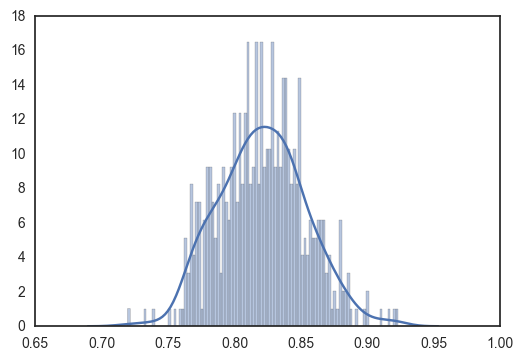

In [416]:
ds3 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
ds = ds3
save_pickle_file(ds3, 'dists_h_none3.p')
fs = [ds[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

In [417]:
low_th, high_th = 0.76, 0.89
small_dist_opts = {col: ds[col] for col in phi_convex_hull.columns if ds[col].fun < low_th}
large_dist_opts = {col: ds[col] for col in phi_convex_hull.columns if ds[col].fun > high_th}
print len(small_dist_opts), len(large_dist_opts)
topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(small_dist_opts, distances_convex_hull)
print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])

5 8
topics to remove =  3
topic_399: распад стандартный_модель вероятность антивещество кварк событие орёл бозон детектор глюон процесс
topic_71: планета атмосфера земля венера планет нептун слой поверхность метан сатурн юпитер
topic_359: тёмный_материя наблюдение тёмный_энергия галактика эпоха скопление_галактика линия скопление плотность красный_смещение космология


In [418]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

In [ ]:
# iteration = 4 

In [ ]:
ds4 = get_optimization_result(hellinger_dist, None, phi_convex_hull, distances_convex_hull)
ds = ds4
save_pickle_file(ds, 'dists_h_none4.p')
fs = [ds[col].fun for col in phi_convex_hull.columns]
sns.distplot(fs, bins=100)

In [ ]:
low_th, high_th = 0.76, 0.89
small_dist_opts = {col: ds[col] for col in phi_convex_hull.columns if ds[col].fun < low_th}
large_dist_opts = {col: ds[col] for col in phi_convex_hull.columns if ds[col].fun > high_th}
print len(small_dist_opts), len(large_dist_opts)
topics_to_remove_by_closest_dist = get_topics_to_remove_by_closest_dist(small_dist_opts, distances_convex_hull)
print 'topics to remove = ', len(topics_to_remove_by_closest_dist)
print '\n'.join([unicode_list_to_str(topic_name, saved_top_tokens[topic_name][0:11]) for topic_name in topics_to_remove_by_closest_dist])

In [ ]:
phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove_by_closest_dist)
distances_convex_hull = remove_topics_from_distances(distances_convex_hull, topics_to_remove_by_closest_dist)

In [ ]:
models_file.close()